In [1]:
pip install aind_dynamic_foraging_basic_analysis

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import json
import seaborn as sns
from datetime import datetime
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
import re

In [3]:
# Load behavior data

# get list of available sessions
file_pattern = "*.nwb"
nwb_folder = "/root/capsule/data/foraging_nwb_bonsai"
file_list = glob.glob(os.path.join(nwb_folder + "/" + file_pattern))
file_names = [os.path.basename(file) for file in file_list]
# file_name = file_names[20]

def parseSessionID(file_name):
    if len(re.split('[_.]', file_name)[0]) == 6:
        aniID = re.split('[_.]', file_name)[0]
        date = re.split('[_.]', file_name)[1]
        dateObj = datetime.strptime(date, "%Y-%m-%d")
    else:
        aniID = None
        dateObj = None
    
    return aniID, dateObj
    
results = [parseSessionID(file_name) for file_name in file_names]
aniIDs, dates = zip(*results)

sessionInfo = pd.DataFrame({'sessionID': file_names,
                            'aniID': aniIDs,
                            'date': dates})
#select animal
anim_name = '716325'
anim_inx = sessionInfo['aniID'] == anim_name
sessionInfo_anim = sessionInfo[anim_inx]
# sessionInfo_anim

#select date
session_date = '05-31-2024'
date_inx = sessionInfo_anim['date'] == session_date
sessionInfo_anim_date = sessionInfo_anim[date_inx]
# sessionInfo_anim_date
#get nwb
session_id = sessionInfo_anim_date['sessionID'].values[0]

nwb_folder = "/root/capsule/data/foraging_nwb_bonsai"
nwb_file = f"{nwb_folder}/{session_id}"
nwb = load_nwb(nwb_file)
nwb

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,reward_random_number_right,left_valve_open_time,right_valve_open_time,block_beta,block_min,block_max,min_reward_each_block,delay_beta,delay_min,delay_max,delay_duration,ITI_beta,ITI_min,ITI_max,ITI_duration,response_duration,reward_consumption_duration,reward_delay,auto_waterL,auto_waterR,laser_on_trial,laser_wavelength,laser_location,laser_1_power,laser_2_power,laser_on_probability,laser_duration,laser_condition,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,session_wide_control,fraction_of_session,session_start_with,session_alternation,minimum_opto_interval,auto_train_engaged,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.892922e+06,3.892973e+06,1.0,False,True,3.892970e+06,3.892971e+06,3.892972e+06,False,True,0.8,0.5,0.9,0.678540,0.399488,0.033,0.031,20.0,20.0,35.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,15.0,15.000000,1.5,1.0,0.2,0,0,0,NaN,None,NaN,NaN,NaN,NaN,None,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,off,0.5,on,on,0.0,True,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6757.0,12218.0,6651.5,2.0,2.0
1,3.892976e+06,3.892986e+06,1.0,False,True,3.892983e+06,3.892984e+06,3.892985e+06,False,True,0.8,0.5,0.9,0.721318,0.547727,0.033,0.031,20.0,20.0,35.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,15.0,7.199677,1.5,1.0,0.2,0,0,0,NaN,None,NaN,NaN,NaN,NaN,None,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,off,0.5,on,on,0.0,True,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6757.0,12218.0,6651.5,2.0,2.0
2,3.892986e+06,3.893002e+06,1.0,False,True,3.892989e+06,3.893001e+06,3.893001e+06,True,True,0.8,0.5,0.9,0.484397,0.724972,0.033,0.031,20.0,20.0,35.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,15.0,2.942915,1.5,1.0,0.2,0,0,0,NaN,None,NaN,NaN,NaN,NaN,None,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,off,0.5,on,on,0.0,True,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6757.0,12218.0,6651.5,2.0,2.0
3,3.893002e+06,3.893036e+06,1.0,False,True,3.893005e+06,3.893035e+06,3.893035e+06,False,True,0.8,0.5,0.9,0.790330,0.347795,0.033,0.031,20.0,20.0,35.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,15.0,3.354985,1.5,1.0,0.2,0,0,0,NaN,None,NaN,NaN,NaN,NaN,None,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,off,0.5,on,on,0.0,True,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6756.5,12218.0,6651.5,2.0,2.0
,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,reward_random_number_right,left_valve_open_time,right_valve_open_time,block_beta,block_min,block_max,min_reward_each_block,delay_beta,delay_min,delay_max,delay_duration,ITI_beta,ITI_min,ITI_max,ITI_duration,response_duration,reward_consumption_duration,reward_delay,auto_waterL,auto_waterR,laser_on_trial,laser_wavelength,laser_location,laser_1_power,laser_2_power,laser_on_probability,laser_duration,laser_condition,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,session_wide_control,fraction_of_session,session_start_with,session_alternation,minimum_opto_interval,auto_train_engaged,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id

In [4]:
#Load kinematics data
from tongue_kinematics_utils import load_keypoints_from_csv
keypoint_dfs = load_keypoints_from_csv('/root/capsule/data/matt_test_DLC_LP_results_20240920/outputs/video_preds3/bottom_camera.csv')
print(keypoint_dfs.keys())
# keypoint_dfs

#get original video csv
video_csv = pd.read_csv('/root/capsule/data/behavior_716325_2024-05-31_10-31-14/behavior-videos/bottom_camera.csv', names = ['Behav_Time','Frame','Camera_Time','Gain','Exposure'])

#assert timebase
def trim_kinematics_timebase_to_match(keypoint_dfs,video_csv):
    """
    trims lightning pose keypoints dataframe OR video csv timebase array to match in length for further processing
    NB: ASSUMES both data structures start at beginning and are aligned-- requires QC
    TODO: figure out why video has one more frame than lightningpose csv file

    Parameters:
    - keypoint_dfs: dataframe from load_keypoints_from_csv
    - video_csv: csv file from original bonsai video acquisition

    Returns:
    - keypoint_dfs_trimmed: trimmed if longer than video_csv, otherwise unchanged
    - video_csv_trimmed: timebase for kinematics data, in time aligned to nwb time. trimmed if longer than keypoint_dfs
    """

    LP_samples = len(keypoint_dfs[list(keypoint_dfs.keys())[0]])
    video_samples = len(video_csv)
    min_samples = np.min([LP_samples,video_samples])

    video_csv_trimmed = video_csv.iloc[:min_samples]
    keypoint_dfs_trimmed = keypoint_dfs.copy()
    for key in keypoint_dfs.keys():
        keypoint_dfs_trimmed[key] = keypoint_dfs[key].iloc[:min_samples]
    
    return keypoint_dfs_trimmed, video_csv_trimmed
keypoint_dfs_trimmed, video_csv_trimmed = trim_kinematics_timebase_to_match(keypoint_dfs,video_csv)
keypoint_timebase = video_csv_trimmed['Behav_Time']

#extract tongue dataframe and mask
from tongue_kinematics_utils import mask_keypoint_data
tongue_masked = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip',confidence_threshold=0.8)
tongue_masked.insert(0,'time',keypoint_timebase-keypoint_timebase[0])


/root/capsule/code/tongue_kinematics_utils.py:217: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_csv)


dict_keys(['nose_tip', 'tongue_tip', 'jaw', 'pointer_finger_l', 'pointer_finger_r', 'spout_l', 'spout_r'])


In [50]:
#example: lickometer vs lightning pose validation

from tongue_lickometer_utils import filter_timestamps_refractory, detect_licks, calculate_metrics

#get all licks
left_licks = nwb.acquisition["left_lick_time"].timestamps - keypoint_timebase[0]
right_licks = nwb.acquisition["right_lick_time"].timestamps - keypoint_timebase[0]
all_licks = np.sort(np.concatenate((right_licks, left_licks)))

#NB R and L are switched due to mislabeling in the training data
mean_spoutL = np.mean(keypoint_dfs_trimmed['spout_r'][['x','y']],0)
mean_spoutR = np.mean(keypoint_dfs_trimmed['spout_l'][['x','y']],0)

#Detect licks based on threshold crossing (pixels) close to either spout
LP_licks_temp = detect_licks(tongue_masked, mean_spoutL, mean_spoutR, 30) 
        

LP_licks_temp = filter_timestamps_refractory(LP_licks_temp, 0.05)

#Calculate true positive, false positive, false negative with 0.1s overal criteria
tp, fp, fn = calculate_metrics(LP_licks_temp, all_licks, 0.1)

tp_rate = tp/len(all_licks)
fp_rate = fp/len(all_licks)
fn_rate = fn/len(LP_licks_temp)

#recall, true positive rate, sensitivity. of true events, how many are detected? recall = tp / (tp + fn)
recall = tp / (tp + fn)

#false negative rate, 1-recall. of true events, how many are not detected? false_negative_rate = fn / (tp + fn)
false_negative_rate = fn / (tp + fn)

#precision, positive predictive value. of detected events, how many are true? precision = tp / (tp + fp)
precision = tp / (tp + fp)

#false discovery rate, 1-precision. of detected events, how many are not true? false_discovery_rate = fp / (tp + fp)
false_discovery_rate = fp / (tp + fp)

print(f'false_negative_rate: {false_negative_rate:.2f}')
print(f'false_discovery_rate: {false_discovery_rate:.2f}')



Filtered 607 events!
false_negative_rate: 0.05
false_discovery_rate: 0.07


In [6]:
# calculate false positive and false negative rate across range of parameter space
from tongue_lickometer_utils import filter_timestamps_refractory, detect_licks, calculate_metrics

#get all licks
left_licks = nwb.acquisition["left_lick_time"].timestamps - keypoint_timebase[0]
right_licks = nwb.acquisition["right_lick_time"].timestamps - keypoint_timebase[0]
all_licks = np.sort(np.concatenate((right_licks, left_licks)))

#NB R and L are switched due to mislabeling in the training data
mean_spoutL = np.mean(keypoint_dfs_trimmed['spout_r'][['x','y']],0)
mean_spoutR = np.mean(keypoint_dfs_trimmed['spout_l'][['x','y']],0)

#parameters to test: 
#1. spatial thresholds for lick detection (in pixels)
#2. time thresholds for overlap between LP and lickometer coincidence (ie whether 'same event' or not)
#3. time thresholds for 'refractory filter' -- removes spurious detection of licks due to oscillation around spatial lick detection threshold
spatial_thresholds = np.arange(10, 51, 5)
time_thresholds = np.arange(0.005, 0.251, .005)
t_refractory_values = np.arange(0, 0.11, 0.01)  
relevant_licks_temp = all_licks

# Initialize results array
results = np.zeros((len(spatial_thresholds), len(time_thresholds), len(t_refractory_values), 3))  # [true_positive, false_positive, false_negative]


for i, spatial_threshold in enumerate(spatial_thresholds):
    # Detect licks based on spatial threshold
    LP_licks_temp = detect_licks(tongue_masked, mean_spoutL, mean_spoutR, spatial_threshold)

    for k, t_refractory in enumerate(t_refractory_values):
        # Filter detected licks based on the current t_refractory value
        LP_licks_filtered = filter_timestamps_refractory(LP_licks_temp, t_refractory)

        for j, time_threshold in enumerate(time_thresholds):
            tp, fp, fn = calculate_metrics(LP_licks_filtered, relevant_licks_temp, time_threshold)
            results[i, j, k] = [tp, fp, fn]

# Now, results will contain metrics for each combination of spatial threshold, time threshold, and t_refractory


Filtered 0 events!
Filtered 105 events!
Filtered 151 events!
Filtered 180 events!
Filtered 194 events!
Filtered 219 events!
Filtered 238 events!
Filtered 246 events!
Filtered 247 events!
Filtered 249 events!
Filtered 251 events!
Filtered 0 events!
Filtered 119 events!
Filtered 205 events!
Filtered 299 events!
Filtered 395 events!
Filtered 477 events!
Filtered 501 events!
Filtered 510 events!
Filtered 512 events!
Filtered 515 events!
Filtered 516 events!
Filtered 0 events!
Filtered 233 events!
Filtered 363 events!
Filtered 537 events!
Filtered 715 events!
Filtered 851 events!
Filtered 887 events!
Filtered 903 events!
Filtered 907 events!
Filtered 909 events!
Filtered 910 events!
Filtered 0 events!
Filtered 284 events!
Filtered 441 events!
Filtered 578 events!
Filtered 702 events!
Filtered 799 events!
Filtered 834 events!
Filtered 855 events!
Filtered 857 events!
Filtered 861 events!
Filtered 863 events!
Filtered 0 events!
Filtered 245 events!
Filtered 368 events!
Filtered 482 events!
Fi

In [55]:
import numpy as np
import pandas as pd
from tongue_lickometer_utils import filter_timestamps_refractory, detect_licks, calculate_metrics

# Get all licks
left_licks = nwb.acquisition["left_lick_time"].timestamps - keypoint_timebase[0]
right_licks = nwb.acquisition["right_lick_time"].timestamps - keypoint_timebase[0]
all_licks = np.sort(np.concatenate((right_licks, left_licks)))

# Mean spout positions
mean_spoutL = np.mean(keypoint_dfs_trimmed['spout_r'][['x','y']], 0)
mean_spoutR = np.mean(keypoint_dfs_trimmed['spout_l'][['x','y']], 0)

# Parameters to test
spatial_thresholds = np.arange(10, 51, 5)
time_thresholds = np.arange(0.005, 0.251, 0.005)
t_refractory_values = np.arange(0, 0.11, 0.01)  
relevant_licks_temp = all_licks

# Initialize a list to collect results
results = []

# Loop through spatial thresholds
for spatial_threshold in spatial_thresholds:
    # Detect licks based on spatial threshold
    LP_licks_temp = detect_licks(tongue_masked, mean_spoutL, mean_spoutR, spatial_threshold)

    # Loop through refractory values
    for t_refractory in t_refractory_values:
        # Filter detected licks based on the current t_refractory value
        LP_licks_filtered = filter_timestamps_refractory(LP_licks_temp, t_refractory)

        # Loop through time thresholds
        for time_threshold in time_thresholds:
            tp, fp, fn = calculate_metrics(LP_licks_filtered, relevant_licks_temp, time_threshold)
            
            # Calculate additional metrics
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            false_negative_rate = fn / (tp + fn) if (tp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0
            
            # Append results to the list
            results.append({
                'spatial_threshold': spatial_threshold,
                'time_threshold': time_threshold,
                't_refractory': t_refractory,
                'true_positive': tp,
                'false_positive': fp,
                'false_negative': fn,
                'recall': recall,
                'false_negative_rate': false_negative_rate,
                'precision': precision,
                'false_discovery_rate': false_discovery_rate
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)



Filtered 0 events!
Filtered 105 events!
Filtered 151 events!
Filtered 180 events!
Filtered 194 events!
Filtered 219 events!
Filtered 238 events!
Filtered 246 events!
Filtered 247 events!
Filtered 249 events!
Filtered 251 events!
Filtered 0 events!
Filtered 119 events!
Filtered 205 events!
Filtered 299 events!
Filtered 395 events!
Filtered 477 events!
Filtered 501 events!
Filtered 510 events!
Filtered 512 events!
Filtered 515 events!
Filtered 516 events!
Filtered 0 events!
Filtered 233 events!
Filtered 363 events!
Filtered 537 events!
Filtered 715 events!
Filtered 851 events!
Filtered 887 events!
Filtered 903 events!
Filtered 907 events!
Filtered 909 events!
Filtered 910 events!
Filtered 0 events!
Filtered 284 events!
Filtered 441 events!
Filtered 578 events!
Filtered 702 events!
Filtered 799 events!
Filtered 834 events!
Filtered 855 events!
Filtered 857 events!
Filtered 861 events!
Filtered 863 events!
Filtered 0 events!
Filtered 245 events!
Filtered 368 events!
Filtered 482 events!
Fi

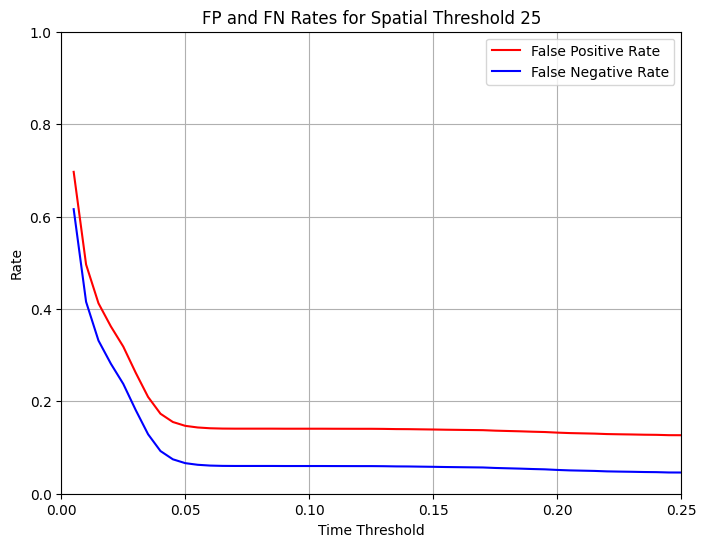

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Choose a specific spatial threshold
spatial_threshold_index = 3  # This corresponds to spatial threshold 25 (since 10, 15, 20, 25...)
spatial_threshold = spatial_thresholds[spatial_threshold_index]

# Extract false positive and false negative rates for this spatial threshold
total_events = len(all_licks)
fp_rates = results[spatial_threshold_index, :, :, 1] / total_events  # False positive rate
fn_rates = results[spatial_threshold_index, :, :, 2] / total_events  # False negative rate

# Use the average rate across refractory values
fp_average = np.mean(fp_rates, axis=1)
fn_average = np.mean(fn_rates, axis=1)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(time_thresholds, fp_average, label='False Positive Rate', color='red')
plt.plot(time_thresholds, fn_average, label='False Negative Rate', color='blue')

# Customizing the plot
plt.title(f'FP and FN Rates for Spatial Threshold {spatial_threshold}')
plt.xlabel('Time Threshold')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)  # Adjust as needed
plt.xlim(0, np.max(time_thresholds))
plt.show()


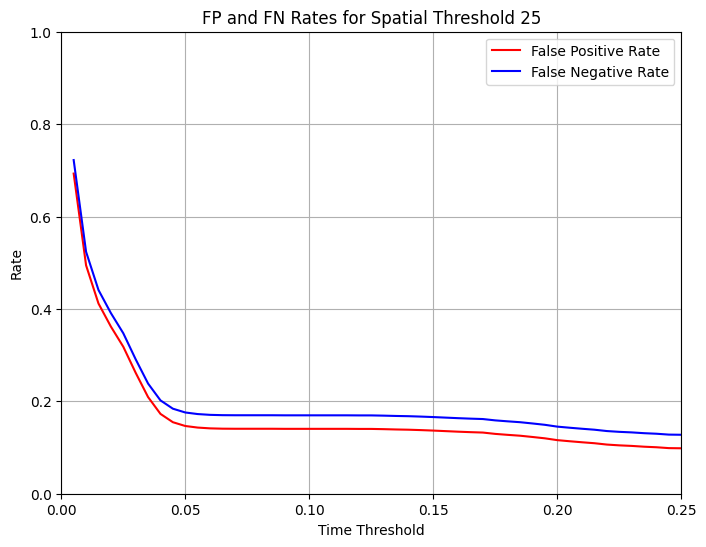

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Choose a specific spatial threshold
spatial_threshold_index = 3  # This corresponds to spatial threshold 25 (since 10, 15, 20, 25...)
spatial_threshold = spatial_thresholds[spatial_threshold_index]

# Extract false positive and false negative rates for this spatial threshold
total_events = len(all_licks)

# Access the FP and FN rates specifically for t_refractory = 0
fp_rates = results[spatial_threshold_index, :, 0, 1] / total_events  # False positive rate at t_refractory = 0
fn_rates = results[spatial_threshold_index, :, 0, 2] / total_events  # False negative rate at t_refractory = 0

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(time_thresholds, fp_rates, label='False Positive Rate', color='red')
plt.plot(time_thresholds, fn_rates, label='False Negative Rate', color='blue')

# Customizing the plot
plt.title(f'FP and FN Rates for Spatial Threshold {spatial_threshold}')
plt.xlabel('Time Threshold')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)  # Adjust as needed
plt.xlim(0, np.max(time_thresholds))
plt.show()


In [13]:
import numpy as np

def find_optimal_rates(results, spatial_thresholds, time_thresholds, t_refractory_values, 
                       all_licks, spatial_range=None, refractory_range=None, time_range=None):
    # Get total events
    total_events = len(all_licks)

    # Get indices for the specified ranges
    if spatial_range is not None:
        spatial_indices = np.where((spatial_thresholds >= spatial_range[0]) & 
                                   (spatial_thresholds <= spatial_range[1]))[0]
    else:
        spatial_indices = np.arange(len(spatial_thresholds))
        
    if refractory_range is not None:
        refractory_indices = np.where((t_refractory_values >= refractory_range[0]) & 
                                      (t_refractory_values <= refractory_range[1]))[0]
    else:
        refractory_indices = np.arange(len(t_refractory_values))
        
    if time_range is not None:
        time_indices = np.where((time_thresholds >= time_range[0]) & 
                                (time_thresholds <= time_range[1]))[0]
    else:
        time_indices = np.arange(len(time_thresholds))

    # Initialize variables to keep track of the best rates and indices
    min_fp_rate = float('inf')
    min_fn_rate = float('inf')
    optimal_fp_params = None
    optimal_fn_params = None

    # Loop through the selected indices
    for spatial_idx in spatial_indices:
        for refractory_idx in refractory_indices:
            for time_idx in time_indices:
                fp_count = results[spatial_idx, time_idx, refractory_idx, 1]  # FP count
                fn_count = results[spatial_idx, time_idx, refractory_idx, 2]  # FN count

                # Calculate rates
                fp_rate = fp_count / total_events
                fn_rate = fn_count / total_events

                # Check for minimum FP rate
                if fp_rate < min_fp_rate:
                    min_fp_rate = fp_rate
                    optimal_fp_params = (spatial_thresholds[spatial_idx], 
                                         t_refractory_values[refractory_idx], 
                                         time_thresholds[time_idx])

                # Check for minimum FN rate
                if fn_rate < min_fn_rate:
                    min_fn_rate = fn_rate
                    optimal_fn_params = (spatial_thresholds[spatial_idx], 
                                         t_refractory_values[refractory_idx], 
                                         time_thresholds[time_idx])

    return (min_fp_rate, optimal_fp_params), (min_fn_rate, optimal_fn_params)

# Example usage
spatial_range = (20, 40)  # Example range for spatial thresholds
refractory_range = (0, .05)  # Only look at t_refractory = 0
time_range = (0.01, 0.11)  # Example range for time thresholds

(fp_rate, fp_params), (fn_rate, fn_params) = find_optimal_rates(
    results, spatial_thresholds, time_thresholds, t_refractory_values, 
    all_licks, spatial_range, refractory_range, time_range
)

print(f'Minimum False Positive Rate: {fp_rate:.4f} at Spatial Threshold: {fp_params[0]}, '
      f'Refractory Time: {fp_params[1]}, Time Threshold: {fp_params[2]}')

print(f'Minimum False Negative Rate: {fn_rate:.4f} at Spatial Threshold: {fn_params[0]}, '
      f'Refractory Time: {fn_params[1]}, Time Threshold: {fn_params[2]}')


Minimum False Positive Rate: 0.0296 at Spatial Threshold: 40, Refractory Time: 0.0, Time Threshold: 0.10500000000000001
Minimum False Negative Rate: 0.0253 at Spatial Threshold: 20, Refractory Time: 0.05, Time Threshold: 0.11


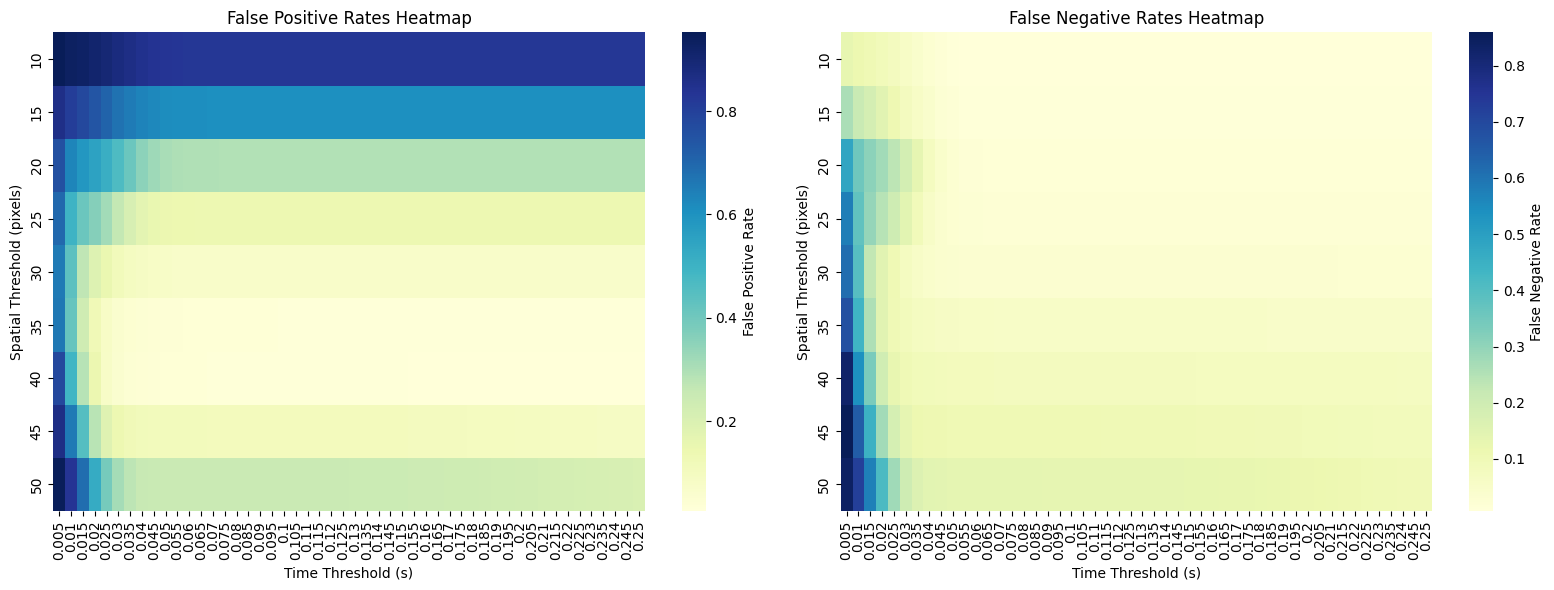

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose a specific refractory value index (e.g., 0)
refractory_idx = 9

# Extract FP and FN rates for the chosen refractory index
fp_rates_heatmap = results[:, :, refractory_idx, 1] / len(all_licks)
fn_rates_heatmap = results[:, :, refractory_idx, 2] / len(all_licks)

# Create a heatmap for FP and FN
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(fp_rates_heatmap, 
             ax=axs[0], 
             xticklabels=time_thresholds.round(3), 
             yticklabels=spatial_thresholds,
             cmap='YlGnBu', 
             cbar_kws={'label': 'False Positive Rate'})
axs[0].set_title('False Positive Rates Heatmap')
axs[0].set_xlabel('Time Threshold (s)')
axs[0].set_ylabel('Spatial Threshold (pixels)')

sns.heatmap(fn_rates_heatmap, 
             ax=axs[1], 
             xticklabels=time_thresholds.round(3), 
             yticklabels=spatial_thresholds,
             cmap='YlGnBu', 
             cbar_kws={'label': 'False Negative Rate'})
axs[1].set_title('False Negative Rates Heatmap')
axs[1].set_xlabel('Time Threshold (s)')
axs[1].set_ylabel('Spatial Threshold (pixels)')

plt.tight_layout()
plt.show()


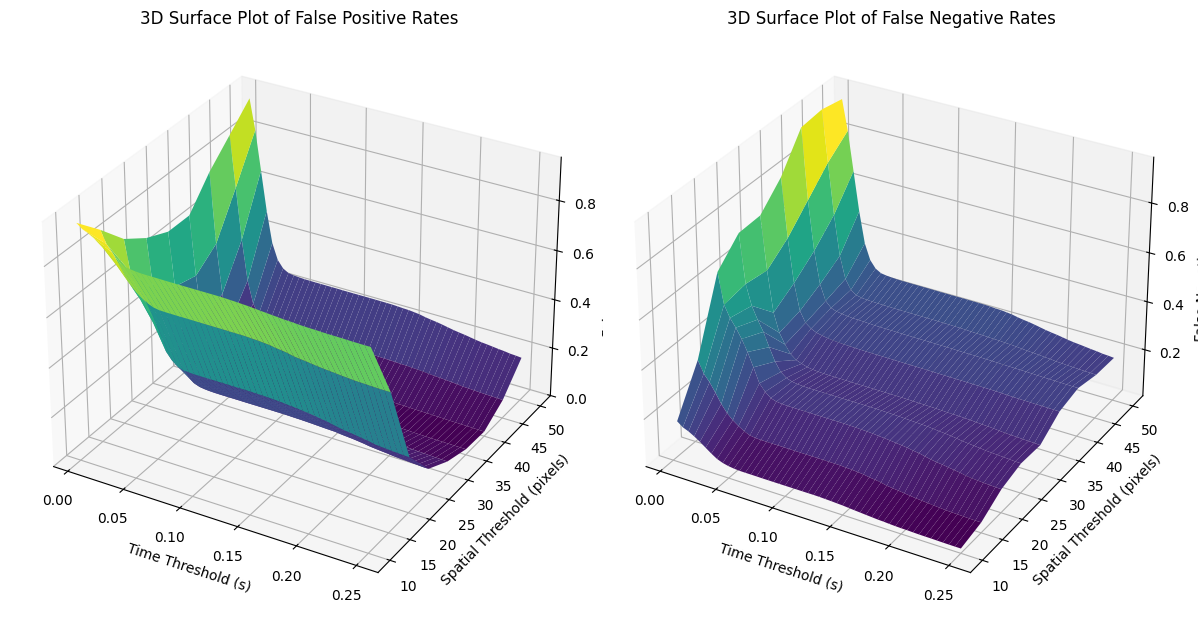

In [23]:
from mpl_toolkits.mplot3d import Axes3D

# Choose a specific refractory value index (e.g., 0)
refractory_idx = 0

# Create a meshgrid for spatial and time thresholds
X, Y = np.meshgrid(time_thresholds, spatial_thresholds)
Z_fp = results[:, :, refractory_idx, 1] / len(all_licks)  # FP rates
Z_fn = results[:, :, refractory_idx, 2] / len(all_licks)  # FN rates

# Plotting
fig = plt.figure(figsize=(12, 10))
ax_fp = fig.add_subplot(121, projection='3d')
ax_fn = fig.add_subplot(122, projection='3d')

# FP Surface
ax_fp.plot_surface(X, Y, Z_fp, cmap='viridis')
ax_fp.set_title('3D Surface Plot of False Positive Rates')
ax_fp.set_xlabel('Time Threshold (s)')
ax_fp.set_ylabel('Spatial Threshold (pixels)')
ax_fp.set_zlabel('False Positive Rate')

# FN Surface
ax_fn.plot_surface(X, Y, Z_fn, cmap='viridis')
ax_fn.set_title('3D Surface Plot of False Negative Rates')
ax_fn.set_xlabel('Time Threshold (s)')
ax_fn.set_ylabel('Spatial Threshold (pixels)')
ax_fn.set_zlabel('False Negative Rate')

plt.tight_layout()
plt.show()


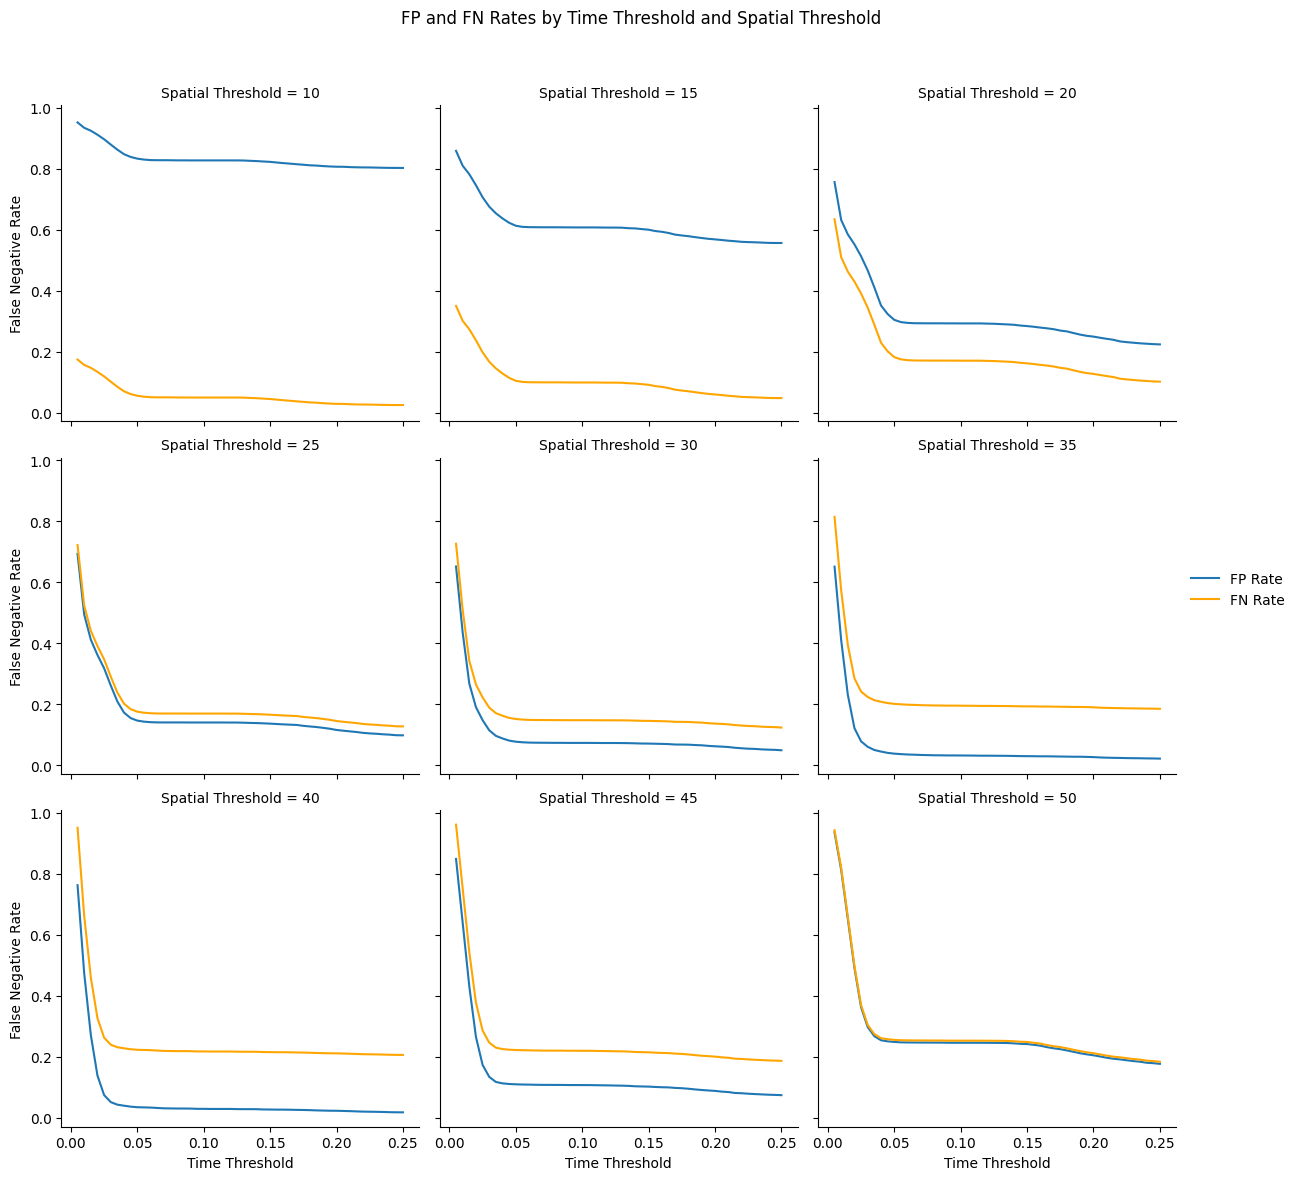

In [24]:
import pandas as pd

# Reshape the results into a DataFrame for easy plotting
data = []
for spatial_idx in range(len(spatial_thresholds)):
    for time_idx in range(len(time_thresholds)):
        fp_rate = results[spatial_idx, time_idx, 0, 1] / len(all_licks)  # FP rate
        fn_rate = results[spatial_idx, time_idx, 0, 2] / len(all_licks)  # FN rate
        data.append((spatial_thresholds[spatial_idx], time_thresholds[time_idx], fp_rate, fn_rate))

df = pd.DataFrame(data, columns=['Spatial Threshold', 'Time Threshold', 'False Positive Rate', 'False Negative Rate'])

# Create a facet grid with subplots
g = sns.FacetGrid(df, col="Spatial Threshold", col_wrap=3, height=4)
g.map(sns.lineplot, "Time Threshold", "False Positive Rate", label='FP Rate')
g.map(sns.lineplot, "Time Threshold", "False Negative Rate", label='FN Rate', color='orange')
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('FP and FN Rates by Time Threshold and Spatial Threshold')
plt.show()


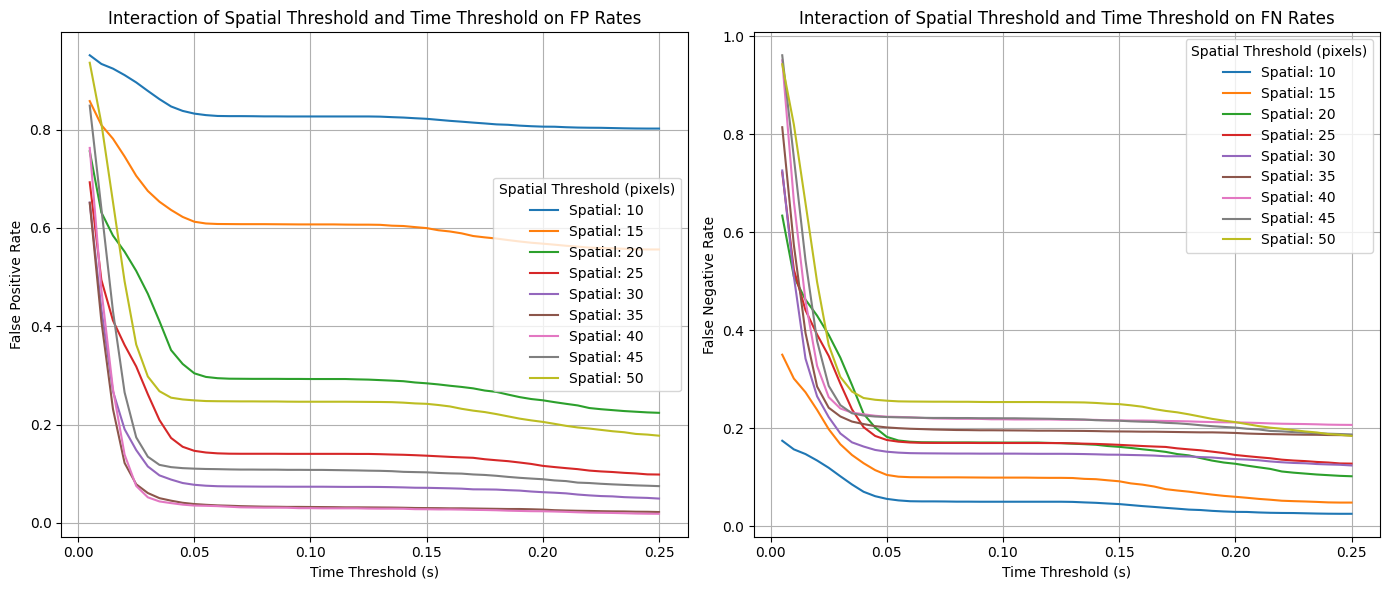

In [26]:
# Create interaction plot with subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# FP interaction plot
for spatial_idx in range(len(spatial_thresholds)):
    axs[0].plot(time_thresholds, results[spatial_idx, :, 0, 1] / len(all_licks), label=f'Spatial: {spatial_thresholds[spatial_idx]}')

axs[0].set_title('Interaction of Spatial Threshold and Time Threshold on FP Rates')
axs[0].set_xlabel('Time Threshold (s)')
axs[0].set_ylabel('False Positive Rate')
axs[0].legend(title='Spatial Threshold (pixels)')
axs[0].grid()

# FN interaction plot
for spatial_idx in range(len(spatial_thresholds)):
    axs[1].plot(time_thresholds, results[spatial_idx, :, 0, 2] / len(all_licks), label=f'Spatial: {spatial_thresholds[spatial_idx]}')

axs[1].set_title('Interaction of Spatial Threshold and Time Threshold on FN Rates')
axs[1].set_xlabel('Time Threshold (s)')
axs[1].set_ylabel('False Negative Rate')
axs[1].legend(title='Spatial Threshold (pixels)')
axs[1].grid()

plt.tight_layout()
plt.show()


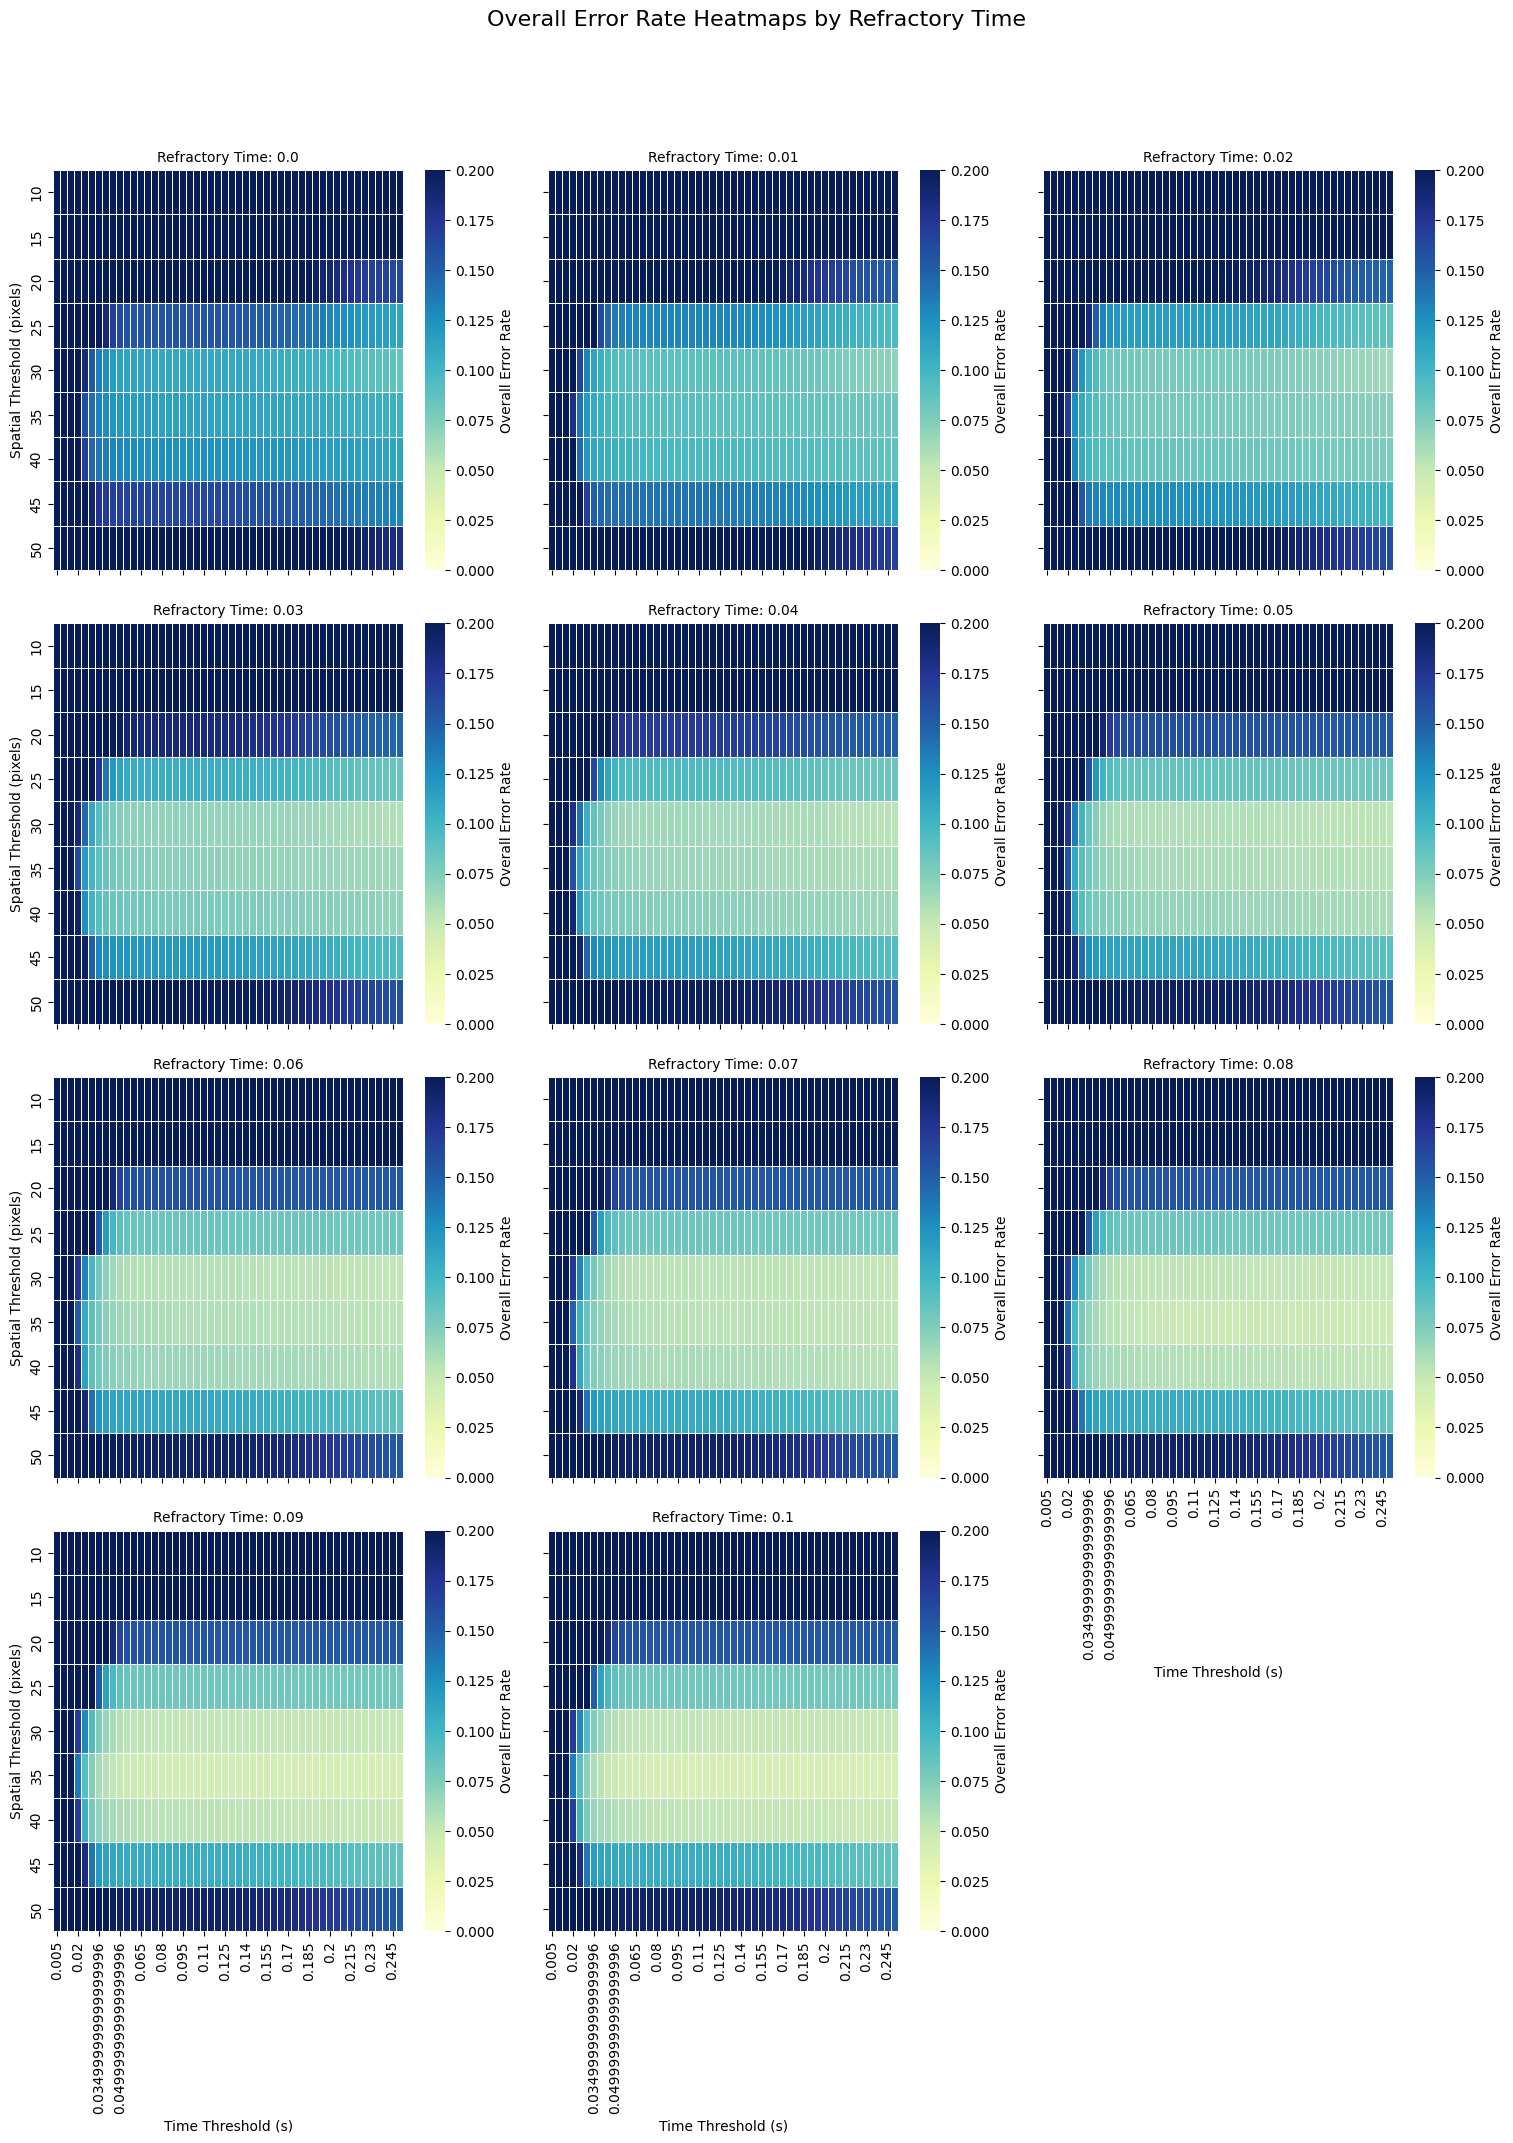

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a DataFrame to hold the overall error rates
data = []

# Loop through the t_refractory values
for k, t_refractory in enumerate(t_refractory_values):
    for i, spatial_threshold in enumerate(spatial_thresholds):
        for j, time_threshold in enumerate(time_thresholds):
            # Calculate FP and FN rates
            fp_rate = results[i, j, k, 1] / len(all_licks)  # FP rate
            fn_rate = results[i, j, k, 2] / len(all_licks)  # FN rate
            overall_error_rate = (fp_rate + fn_rate) / 2
            
            # Append to the DataFrame
            data.append((spatial_threshold, time_threshold, t_refractory, overall_error_rate))

# Create a DataFrame
df = pd.DataFrame(data, columns=['Spatial Threshold', 'Time Threshold', 'Refractory Time', 'Overall Error Rate'])

# Create a facet grid with heatmaps
g = sns.FacetGrid(df, col="Refractory Time", col_wrap=3, height=5)

# Loop through each t_refractory value and create a heatmap
for k, t_refractory in enumerate(t_refractory_values):
    # Filter the DataFrame for the current refractory time
    filtered_df = df[df['Refractory Time'] == t_refractory]

    # Pivot the filtered data
    pivot_data = filtered_df.pivot_table(index="Spatial Threshold", 
                                          columns="Time Threshold", 
                                          values="Overall Error Rate", 
                                          aggfunc='mean')  # Ensure we take the mean if needed

    # Create the heatmap
    ax = g.axes[k]
    
    # Make sure we are plotting only the relevant data
    sns.heatmap(pivot_data, ax=ax, cmap='YlGnBu', 
                cbar_kws={'label': 'Overall Error Rate'}, 
                annot=False, linewidths=.5,
                vmin=0.0, vmax=0.2)

    # # Remove tick labels
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])

# Customize the plots
g.set_axis_labels('Time Threshold (s)', 'Spatial Threshold (pixels)')
g.set_titles(col_template='Refractory Time: {col_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Overall Error Rate Heatmaps by Refractory Time', fontsize=16)

plt.show()

In [52]:
df

,Spatial Threshold,Time Threshold,Refractory Time,Overall Error Rate
0,10,0.005,0.0,0.562863
1,10,0.010,0.0,0.545245
2,10,0.015,0.0,0.535665
3,10,0.020,0.0,0.522494
4,10,0.025,0.0,0.507612
...,...,...,...,...
4945,50,0.230,0.1,0.158399
4946,50,0.235,0.1,0.157202
4947,50,0.240,0.1,0.154465
4948,50,0.245,0.1,0.152583


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Choose the indices for the spatial thresholds to plot
spatial_threshold_indices = [0,2,4,6]  

# Create a color map for intensity based on spatial thresholds
colors = cm.viridis(np.linspace(0, 1, len(spatial_threshold_indices)))

# Create the plot
plt.figure(figsize=(12, 6))

for idx, spatial_threshold_index in enumerate(spatial_threshold_indices):
    spatial_threshold = spatial_thresholds[spatial_threshold_index]

    # Extract false positive and false negative rates for this spatial threshold
    fp_rates = results[spatial_threshold_index, :, :, 1] / total_events  # False positive rate
    fn_rates = results[spatial_threshold_index, :, :, 2] / total_events  # False negative rate

    # Average rates across refractory values
    fp_average = np.mean(fp_rates, axis=1)
    fn_average = np.mean(fn_rates, axis=1)

    # Plot FP and FN rates with fixed colors
    plt.plot(time_thresholds, fp_average, label=f'FP (Spatial: {spatial_threshold})', color='red', alpha=colors[idx][0])
    plt.plot(time_thresholds, fn_average, label=f'FN (Spatial: {spatial_threshold})', color='blue', alpha=colors[idx][0])

# Customizing the plot
plt.title('FP and FN Rates for Various Spatial Thresholds')
plt.xlabel('Time Threshold')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)  # Adjust as needed
plt.xlim(np.min(time_thresholds), np.max(time_thresholds))
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a color map for intensity based on spatial thresholds
colors = np.linspace(0.3, 1, len(spatial_thresholds))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for idx, spatial_threshold in enumerate(spatial_thresholds):
    # Extract false positive and false negative rates for this spatial threshold
    fp_rates = results[idx, :, :, 1] / total_events  # False positive rate
    fn_rates = results[idx, :, :, 2] / total_events  # False negative rate

    # Average rates across refractory values
    fp_average = np.mean(fp_rates, axis=1)
    fn_average = np.mean(fn_rates, axis=1)

    # Use the alpha value from the color intensity for transparency
    alpha_value = colors[idx]

    # Plot FP rates
    ax1.plot(time_thresholds, fp_average, label=f'Spatial: {spatial_threshold}', color='red', alpha=alpha_value)

    # Plot FN rates
    ax2.plot(time_thresholds, fn_average, label=f'Spatial: {spatial_threshold}', color='blue', alpha=alpha_value)

# Customizing the FP subplot
ax1.set_title('False Positive Rates')
ax1.set_xlabel('Time Threshold')
ax1.set_ylabel('Rate')
ax1.grid(True)
ax1.set_ylim(0, 1)  # Adjust as needed
ax1.set_xlim(np.min(time_thresholds), np.max(time_thresholds))
ax1.legend(loc='upper right')

# Customizing the FN subplot
ax2.set_title('False Negative Rates')
ax2.set_xlabel('Time Threshold')
ax2.set_ylabel('Rate')
ax2.grid(True)
ax2.set_ylim(0, 1)  # Adjust as needed
ax2.set_xlim(np.min(time_thresholds), np.max(time_thresholds))
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Loop through all spatial thresholds
for idx, spatial_threshold in enumerate(spatial_thresholds):
    # Extract false positive and false negative rates for this spatial threshold
    fp_rates = results[idx, :, :, 1] / total_events  # False positive rate
    fn_rates = results[idx, :, :, 2] / total_events  # False negative rate

    # Average rates across refractory values
    fp_average = np.mean(fp_rates, axis=1)
    fn_average = np.mean(fn_rates, axis=1)

    # Use a color map for FP (plasma) and FN (cividis)
    fp_color = cm.plasma((idx + 1) / len(spatial_thresholds))  # More intense color for higher thresholds
    fn_color = cm.cividis((idx + 1) / len(spatial_thresholds))

    # Plot FP rates
    ax1.plot(time_thresholds, fp_average, label=f'Spatial: {spatial_threshold}', color=fp_color)

    # Plot FN rates
    ax2.plot(time_thresholds, fn_average, label=f'Spatial: {spatial_threshold}', color=fn_color)

# Customizing the FP subplot
ax1.set_title('False Positive Rates')
ax1.set_xlabel('Time Threshold')
ax1.set_ylabel('Rate')
ax1.grid(True)
ax1.set_ylim(0, 1)  # Adjust as needed
ax1.set_xlim(np.min(time_thresholds), np.max(time_thresholds))
ax1.legend(loc='upper right')

# Customizing the FN subplot
ax2.set_title('False Negative Rates')
ax2.set_xlabel('Time Threshold')
ax2.set_ylabel('Rate')
ax2.grid(True)
ax2.set_ylim(0, 1)  # Adjust as needed
ax2.set_xlim(np.min(time_thresholds), np.max(time_thresholds))
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
